In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn import metrics
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import sqlite3
import pandas as pd
import json

C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    device = torch.device('cpu')
    print("MPS device not found.")

MPS device not found.


In [5]:
 
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))
nltk_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [6]:
from io import StringIO
from html.parser import HTMLParser
from bs4 import BeautifulSoup

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def get_latex_from_alt(context):
    strip_deliminators = lambda latex: latex.replace('$','').replace('\\[','').replace('\\]','')

    context_soup = BeautifulSoup(context)
    latex_images = context_soup.find_all('img')
    for image in latex_images:
        image.replace_with(strip_deliminators(image['alt']))
    # return [strip_deliminators(image['alt']) for image in latex_images]
    return str(context_soup)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def remove_stopwords(text):
    filtered_text = [w for w in text.split() if w.lower() not in nltk_stopwords]
    return " ".join(filtered_text)

In [7]:
get_latex_from_alt('<html><head></head><body><p>In the following list of numbers, the integer <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> appears <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> times in the list for <img alt=\"$1 \\leq n \\leq 200$\" class=\"latex\" height=\"15\" src=\"//latex.artofproblemsolving.com/9/1/7/917e3430450e9049864739d088103bef0598a899.png\" style=\"vertical-align: -2px\" width=\"95\"/>.<img alt=\"\\[1, 2, 2, 3, 3, 3, 4, 4, 4, 4, \\ldots, 200, 200, \\ldots , 200\\]\" class=\"latexcenter\" height=\"16\" src=\"//latex.artofproblemsolving.com/f/4/f/f4f50e6ad3c33b14e7352b50ecc5ff8322c37702.png\" width=\"332\"/>What is the median of the numbers in this list?\n</p><p>\n</p></body></html>')
remove_stopwords('value x satisfies x- \\frac{3}{4} = \\frac{5}{12} - \\frac{1}{3}? Adding \\frac{3}{4} sides, x= \\frac{5}{12} - \\frac{1}{3} + \\frac{3}{4} = \\frac{5}{12} - \\frac{4}{12} + \\frac{9}{12}=\\boxed{\\textbf{(E) }\\frac{5}{6}}. Multiplying 12 sides gets us 12x-9=1 \\Rightarrow 12x=10, therefore \\boxed{x=\\textbf{(E)}~\\frac{5}{6}}. \\ {-}\\frac{2}{3} \\ \\frac{7}{36} \\ \\frac{7}{12} \\ \\frac{2}{3} \\ \\frac{5}{6}')

'value x satisfies x- \\frac{3}{4} = \\frac{5}{12} - \\frac{1}{3}? Adding \\frac{3}{4} sides, x= \\frac{5}{12} - \\frac{1}{3} + \\frac{3}{4} = \\frac{5}{12} - \\frac{4}{12} + \\frac{9}{12}=\\boxed{\\textbf{(E) }\\frac{5}{6}}. Multiplying 12 sides gets us 12x-9=1 \\Rightarrow 12x=10, therefore \\boxed{x=\\textbf{(E)}~\\frac{5}{6}}. \\ {-}\\frac{2}{3} \\ \\frac{7}{36} \\ \\frac{7}{12} \\ \\frac{2}{3} \\ \\frac{5}{6}'

In [8]:
con = sqlite3.connect('site/amc10_problems.db')

cursor = con.cursor()
cursor.execute('SELECT * FROM problem')

problems_data = pd.DataFrame(cursor.fetchall(), columns=['id','test','number','choices','problem','answer','solutions','labels','difficulty'])

OperationalError: unable to open database file

: 

In [ ]:
problems_data['test'] = problems_data['test'].apply(json.loads)
problems_data['solutions'] = problems_data['solutions'].apply(lambda x: " ".join([solution for solution in json.loads(x) 
                                                                                    if 'http' not in solution]))
problems_data['year'] = problems_data['test'].apply(lambda x: str(x[0]))
problems_data['instance'] = problems_data['test'].apply(lambda x: x[2])

problems_data.head(5)

,id,test,number,choices,problem,answer,solutions,labels,difficulty,year,instance
0,1,"[2015, 10, A]",1,"[""\\ -125"", ""\\ -120"", ""\\ \\frac{1}{5}"", ""\\ ...",<html><head></head><body><p>What is the value ...,C,"<p><img alt=""$(2^0-1+5^2-0)^{-1}\times5 = (1-1...",None,1,2015,A
1,2,"[2015, 10, A]",2,"[""\\ 3"", ""\\ 5"", ""\\ 7"", ""\\ 9"", ""\\ 11""]",<html><head></head><body><p>A box contains a c...,D,"<p>Let <img alt=""$a$"" class=""latex"" height=""8""...",None,1,2015,A
2,3,"[2015, 10, A]",3,"[""\\ 9"", ""\\ 18"", ""\\ 20"", ""\\ 22"", ""\\ 24""]",<html><head></head><body><p>Ann made a <img al...,D,"<p>We can see that a <img alt=""$1$"" class=""lat...",None,1,2015,A
3,4,"[2015, 10, A]",4,"[""\\ \\frac{1}{12}"", ""\\ \\frac{1}{6}"", ""\\ \\...","<html><head></head><body><p>Pablo, Sofia, and ...",B,<p>Assign a variable to the number of eggs Mia...,None,1,2015,A
4,5,"[2015, 10, A]",5,"[""\\ 81"", ""\\ 85"", ""\\ 91"", ""\\ 94"", ""\\ 95""]",<html><head></head><body><p>Mr. Patrick teache...,E,"<p>If the average of the first <img alt=""$14$""...",None,1,2015,A


In [ ]:
problems_data['year'].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2021_Fall', '2022'], dtype=object)

In [ ]:
problems_data = problems_data[problems_data['year'].isin(['2019','2020', '2021_Fall', '2021', '2022'])]
problems_data.set_index('id')

,test,number,choices,problem,answer,solutions,labels,difficulty,year,instance
id,,,,,,,,,,
200,"[2019, 10, A]",1,"["" 0 "", "" 1 "", "" 2 "", "" 3 "", "" 4""]",<html><head></head><body><p>What is the value ...,C,"<p><img alt=""$2^{\left(0^{\left(1^9\right)}\ri...",None,1,2019,A
201,"[2019, 10, A]",2,"[""0"", ""1"", ""2"", ""4"", ""5""]",<html><head></head><body><p>What is the hundre...,A,"<p>Because we know that <img alt=""$5^3$"" class...",None,1,2019,A
202,"[2019, 10, A]",3,"["" 3 "", "" 5 "", "" 9 "", "" 12 "", "" 15""]",<html><head></head><body><p>Ana and Bonita wer...,D,"<p>Let <img alt=""$A$"" class=""latex"" height=""13...",None,1,2019,A
203,"[2019, 10, A]",4,"["" 75 "", "" 76 "", "" 79 "", "" 84 "", "" 91""]",<html><head></head><body><p>A box contains <im...,B,<p>We try to find the worst case scenario wher...,None,1,2019,A
204,"[2019, 10, A]",5,"["" 9 "", "" 25 "", "" 45 "", "" 90 "", "" 120""]",<html><head></head><body><p>What is the greate...,D,<p>We might at first think that the answer wou...,None,1,2019,A
...,...,...,...,...,...,...,...,...,...,...
445,"[2022, 10, B]",21,"[""\\ 10 "", ""\\ 13 "", ""\\ 19 "", ""\\ 20 "", ""\\ 23""]","<html><head></head><body><p>Let <img alt=""$P(x...",E,<p>Given that all the answer choices and coeff...,None,5,2022,B
446,"[2022, 10, B]",22,"[""~48\\pi"", ""~68\\pi"", ""~96\\pi"", ""~102\\pi"", ...","<html><head></head><body><p>Let <img alt=""$S$""...",E,"<p><img alt=""[asy] import geometry; ...",None,5,2022,B
447,"[2022, 10, B]",23,"[""\\frac{1}{3} "", ""\\frac{1}{2} "", ""\\frac{2...",<html><head></head><body><p>Ant Amelia starts ...,C,"<p>Let <img alt=""$x$"" class=""latex"" height=""8""...",None,5,2022,B


In [ ]:
labeled_data = pd.read_csv('problem_labels.csv').replace([True,False],[1,0])
labeled_data.shape

(250, 85)

In [ ]:
labeled_data

,Year,Level,Instance,Problem,Arithmetic,Word Problems,Fractions/Percentages,Tracing,Strategy/Answer Choices,Exponentiation/nth Roots,...,Placing/Picking/Labeling Problems,Stars and Bars,Expected Value,Recursive Counting,Conditional Probability,Pigeonhole Principle,Complementary Counting,States,Principle of Inclusion-Exclusion,Geometric Probability
0,2022,10,A,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022,10,A,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022,10,A,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022,10,A,4,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022,10,A,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019,10,B,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,2019,10,B,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
247,2019,10,B,23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248,2019,10,B,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
misc_labels = (4,23)
alg_labels = (23,44)
geo_labels = (44,60)
nt_labels = (60,68)
cb_labels = (68,85)

def extract_labels(cols):
    start, end = cols
    return labeled_data[labeled_data.columns[start:end]].values.tolist()

In [ ]:
labeled_data['misc-labels'] = extract_labels(misc_labels)
labeled_data['alg-labels'] = extract_labels(alg_labels)
labeled_data['geo-labels'] = extract_labels(geo_labels)
labeled_data['nt-labels'] = extract_labels(nt_labels)
labeled_data['cb-labels'] = extract_labels(cb_labels)

labeled_data['Miscellaneous'] = labeled_data['misc-labels'].apply(lambda x: int(any(x)))
labeled_data['Combinatorics'] = labeled_data['cb-labels'].apply(lambda x: int(any(x)))

NameError: name 'extract_labels' is not defined

In [ ]:
labeled_data

,Year,Level,Instance,Problem,Arithmetic,Word Problems,Fractions/Percentages,Tracing,Strategy/Answer Choices,Exponentiation/nth Roots,...,States,Principle of Inclusion-Exclusion,Geometric Probability,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,Miscellaneous,Combinatorics
0,2022,10,A,1,1,0,1,0,0,0,...,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
1,2022,10,A,2,1,1,0,0,0,0,...,0,0,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
2,2022,10,A,3,0,1,0,0,0,0,...,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
3,2022,10,A,4,0,1,1,0,0,0,...,0,0,0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
4,2022,10,A,5,0,0,0,0,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019,10,B,21,0,0,0,0,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1
246,2019,10,B,22,0,0,0,0,0,0,...,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0,1
247,2019,10,B,23,0,0,0,0,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
248,2019,10,B,24,0,0,0,0,0,0,...,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0


In [ ]:
labeled_data['tl-labels'] = labeled_data[['Miscellaneous','Algebra','Geometry','Number Theory','Combinatorics']].values.tolist()

labeled_data = labeled_data[['Year','Instance','Problem',
                             'Miscellaneous','Algebra','Geometry','Number Theory','Combinatorics',
                             'misc-labels','alg-labels','geo-labels','nt-labels','cb-labels','tl-labels',]]
labeled_data

,Year,Instance,Problem,Miscellaneous,Algebra,Geometry,Number Theory,Combinatorics,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,tl-labels
0,2022,A,1,1,1,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0]"
1,2022,A,2,1,0,0,0,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]"
2,2022,A,3,1,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]"
3,2022,A,4,1,1,0,0,0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0]"
4,2022,A,5,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2019,B,21,1,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1]"
246,2019,B,22,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 1]"
247,2019,B,23,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0]"
248,2019,B,24,1,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]"


In [ ]:
problems_data = problems_data[['year','instance','number','choices','problem','solutions']]
problems_data['problem'] = problems_data['problem'].map(lambda x: strip_tags(get_latex_from_alt(x)))
problems_data['solutions'] = problems_data['solutions'].map(lambda x: strip_tags(get_latex_from_alt(x)))
problems_data['choices'] = problems_data['choices'].map(lambda x: ' '.join(json.loads(x)))
problems_data['context'] = problems_data['problem'] + problems_data['solutions'] + problems_data['choices'] 
problems_data['context'] = problems_data['context'].map(remove_stopwords)
problems_data.drop(columns=['problem','choices','solutions'],inplace=True)
labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)

/var/folders/h1/88vswkjs65x3v7m1ytlwgpy40000gp/T/ipykernel_7789/2196254196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data.rename(columns={'Year':'year', 'Instance':'instance', 'Problem':'number'}, inplace=True)


In [ ]:
problems_data = problems_data.merge(right=labeled_data,on=['year','instance','number'])
problems_data

,year,instance,number,context,Miscellaneous,Algebra,Geometry,Number Theory,Combinatorics,misc-labels,alg-labels,geo-labels,nt-labels,cb-labels,tl-labels
0,2019,A,1,value 2^{\left(0^{\left(1^9\right)}\right)}+\l...,1,0,0,0,0,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]"
1,2019,A,2,hundreds digit (20!-15!)? know 5^3 factor 15! ...,0,0,0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0]"
2,2019,A,3,"Ana Bonita born date different years, n years ...",1,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]"
3,2019,A,4,"box contains 28 red balls, 20 green balls, 19 ...",0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 1]"
4,2019,A,5,greatest number consecutive integers whose sum...,1,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2022,B,21,Let P(x) polynomial rational coefficients P(x)...,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0]"
246,2022,B,22,Let set circles coordinate plane tangent three...,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0]"
247,2022,B,23,Ant Amelia starts number line 0 crawls followi...,1,0,0,0,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1]"
248,2022,B,24,Consider functions f satisfy |f(x)-f(y)|\leq \...,1,1,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0]"


In [ ]:
problems_data['context'].iloc[0]

'value 2^{\\left(0^{\\left(1^9\\right)}\\right)}+\\left(\\left(2^0\\right)^1\\right)^9? 2^{\\left(0^{\\left(1^9\\right)}\\right)}+\\left(\\left(2^0\\right)^1\\right)^9 = 1+1 = \\boxed{2} corresponds \\boxed{\\text{C}}. 0 1 2 3 4'

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 1e-05

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',truncation_side='left',truncation=True)
tokenizer.add_tokens(list(open('latex-vocabulary/latex_symbols.txt','r')))

13855

In [ ]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, labels, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['context']
        self.targets = dataframe[labels]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8
training_data = problems_data.sample(frac=train_size, random_state=200).reset_index(drop=True)
validation_data = problems_data.drop(training_data.index).reset_index(drop=True)

In [ ]:
training_dataset = MultiLabelDataset(training_data, tokenizer, 'tl-labels', MAX_LEN)
val_dataset = MultiLabelDataset(validation_data, tokenizer, 'tl-labels', MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_dataset, **train_params)
testing_loader = DataLoader(val_dataset, **test_params)

In [ ]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        return self.classifier(pooler)

In [ ]:
top_level_model = DistilBERTClass(num_classes=5)
top_level_model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  top_level_model.parameters(), lr=LEARNING_RATE)

In [ ]:
class ModelTraining:
    def __init__(self, model, training_loader, testing_loader, optimizer):
        self.model = model
        self.training_loader = training_loader
        self.optimizer = optimizer
        self.testing_loader = testing_loader
    
    def train_model(self,epoch):
        self.model.train()
        for _, data in enumerate(self.training_loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            
            outputs = self.model(ids, mask)

            self.optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            if _%1000==0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}')
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def validation(self):
        self.model.eval()
        fin_targets=[]
        fin_outputs=[]
        with torch.no_grad():
            for _, data in enumerate(self.testing_loader):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = self.model(ids, mask)
                fin_targets.extend(targets.cpu().detach().numpy().tolist())
                fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        return fin_outputs, fin_targets

In [ ]:
tl_model_trainer = ModelTraining(top_level_model,training_loader,testing_loader,optimizer)
for epoch in range(EPOCHS):
    tl_model_trainer.train_model(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.6837949752807617
Epoch: 1, Loss: 0.5607002377510071
Epoch: 2, Loss: 0.5450284481048584
Epoch: 3, Loss: 0.5833237171173096
Epoch: 4, Loss: 0.4789879620075226
Epoch: 5, Loss: 0.4468652009963989
Epoch: 6, Loss: 0.365799218416214
Epoch: 7, Loss: 0.34791508316993713
Epoch: 8, Loss: 0.3807273507118225
Epoch: 9, Loss: 0.3308659791946411
Epoch: 10, Loss: 0.3573678731918335
Epoch: 11, Loss: 0.2380899339914322
Epoch: 12, Loss: 0.16878747940063477
Epoch: 13, Loss: 0.20532914996147156
Epoch: 14, Loss: 0.2317701280117035
Epoch: 15, Loss: 0.155557319521904
Epoch: 16, Loss: 0.10305856913328171
Epoch: 17, Loss: 0.186761274933815
Epoch: 18, Loss: 0.06845510005950928
Epoch: 19, Loss: 0.08109410107135773
Epoch: 20, Loss: 0.0886944979429245
Epoch: 21, Loss: 0.06428487598896027
Epoch: 22, Loss: 0.0850638598203659
Epoch: 23, Loss: 0.04513505473732948
Epoch: 24, Loss: 0.0515405647456646
Epoch: 25, Loss: 0.05938776955008507
Epoch: 26, Loss: 0.08582205325365067
Epoch: 27, Loss: 0.052041850984

In [ ]:
torch.save(top_level_model,'top-level-with-solutions-distilbert-amc10-2019-2022.pt')

In [ ]:
# model = torch.load('top-level-distilbert-amc10-2020-2022.pt')

In [ ]:
# def validation(testing_loader):
#     model.eval()
#     fin_targets=[]
#     fin_outputs=[]
#     with torch.no_grad():
#         for _, data in enumerate(testing_loader):
#             ids = data['ids'].to(device, dtype = torch.long)
#             mask = data['mask'].to(device, dtype = torch.long)
#             # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
#             targets = data['targets'].to(device, dtype = torch.float)
#             outputs = top_level_model(ids, mask)
#             fin_targets.extend(targets.cpu().detach().numpy().tolist())
#             fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
#     return fin_outputs, fin_targets

Accuracy Score = 0.9
F1 Score (Micro) = 0.9315068493150686
F1 Score (Macro) = 0.9177379142596533


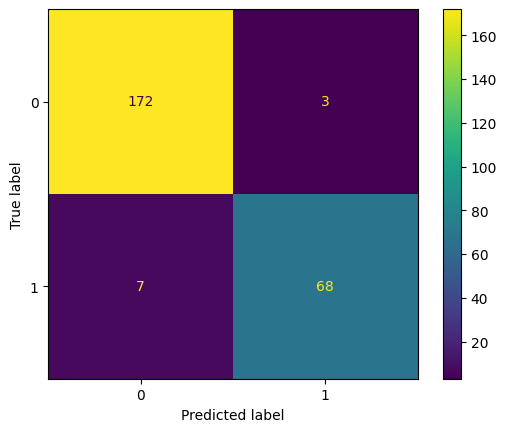

In [ ]:
from itertools import chain

outputs, targets = tl_model_trainer.validation()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                             list(chain.from_iterable(outputs))))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

In [ ]:
# for cm in metrics.multilabel_confusion_matrix(targets,outputs):
#     matrix = metrics.ConfusionMatrixDisplay(cm)
#     matrix.plot()
# single_label_accuracy = metrics.accuracy_score(list(chain.from_iterable(targets)), list(chain.from_iterable(outputs)))
# print(f"Single-label Accuracy Score = {single_label_accuracy}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


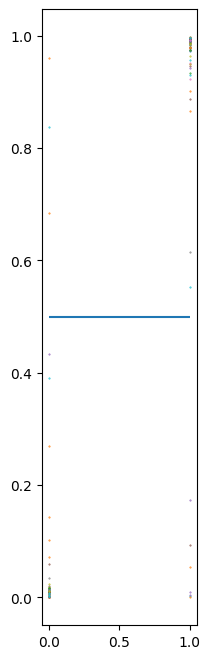

In [ ]:
outputs, targets = tl_model_trainer.validation()

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

In [ ]:
def generate_model(dataframe, labels):
    training_data = dataframe.sample(frac=train_size, random_state=200).reset_index(drop=True)
    validation_data = dataframe.drop(training_data.index).reset_index(drop=True)

    training_dataset = MultiLabelDataset(training_data, tokenizer, labels, MAX_LEN)
    val_dataset = MultiLabelDataset(validation_data, tokenizer, labels, MAX_LEN)

    training_loader = DataLoader(training_dataset, **train_params)
    testing_loader = DataLoader(val_dataset, **test_params)

    model = DistilBERTClass(len(dataframe[labels].iloc[0]))
    model.to(device)

    return model, training_loader, testing_loader

In [ ]:
alg_data = problems_data.loc[problems_data['Algebra'] == True]
alg_data = alg_data[['year','instance','number','context','alg-labels']].reset_index()
alg_data

,index,year,instance,number,context,alg-labels
0,18,2019,A,19,least possible value (x+1)(x+2)(x+3)(x+4)+2019...,"[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,23,2019,A,24,"Let p, q, r distinct roots polynomial x^3 - 22...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,30,2019,B,6,positive integer n (n+1)! + (n+2)! = n! \cdot ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,33,2019,B,9,function f defined f(x) = \lfloor|x|\rfloor - ...,"[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,50,2020,A,1,value x satisfies x- \frac{3}{4} = \frac{5}{12...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,51,2020,A,2,"numbers 3, 5, 7, a, b average (arithmetic mean...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,52,2020,A,3,"Assuming a\neq3, b\neq4, c\neq5, value simples...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,53,2020,A,4,"driver travels 2 hours 60 miles per hour, car ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
8,54,2020,A,5,sum real numbers x |x^2-12x+34|=2? Split equat...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,57,2020,A,8,value 1+2+3-4+5+6+7-8+\cdots+197+198+199-200? ...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
alg_model, alg_training_loader, alg_testing_loader = generate_model(alg_data, 'alg-labels')
alg_optimizer = torch.optim.Adam(params=alg_model.parameters(), lr=LEARNING_RATE)
alg_model_trainer = ModelTraining(alg_model, alg_training_loader, alg_testing_loader, alg_optimizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for epoch in range(EPOCHS):
    alg_model_trainer.train_model(epoch)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.693421483039856
Epoch: 1, Loss: 0.6455314755439758
Epoch: 2, Loss: 0.5926631093025208
Epoch: 3, Loss: 0.5174912810325623
Epoch: 4, Loss: 0.4797419309616089
Epoch: 5, Loss: 0.46441853046417236
Epoch: 6, Loss: 0.39479532837867737
Epoch: 7, Loss: 0.4014852046966553
Epoch: 8, Loss: 0.38672542572021484
Epoch: 9, Loss: 0.3865765333175659
Epoch: 10, Loss: 0.33706891536712646
Epoch: 11, Loss: 0.33911746740341187
Epoch: 12, Loss: 0.35765331983566284
Epoch: 13, Loss: 0.3537326157093048
Epoch: 14, Loss: 0.29890376329421997
Epoch: 15, Loss: 0.3367793560028076
Epoch: 16, Loss: 0.2758176326751709
Epoch: 17, Loss: 0.29296037554740906
Epoch: 18, Loss: 0.27723467350006104
Epoch: 19, Loss: 0.3063593804836273
Epoch: 20, Loss: 0.2762730121612549
Epoch: 21, Loss: 0.2999330163002014
Epoch: 22, Loss: 0.2652958035469055
Epoch: 23, Loss: 0.26662859320640564
Epoch: 24, Loss: 0.24702344834804535
Epoch: 25, Loss: 0.21922923624515533
Epoch: 26, Loss: 0.24743039906024933
Epoch: 27, Loss: 0.2229030

In [ ]:
torch.save(alg_model,'algebra-model-distilbert-amc10-2019-2022.pt')

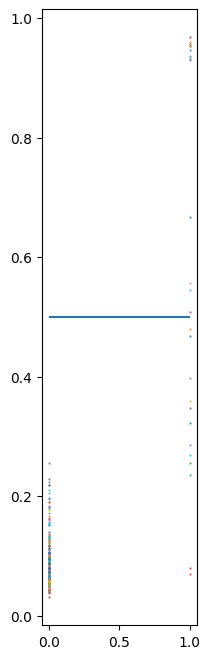

Accuracy Score = 0.948051948051948
Recall = 0.5714285714285714


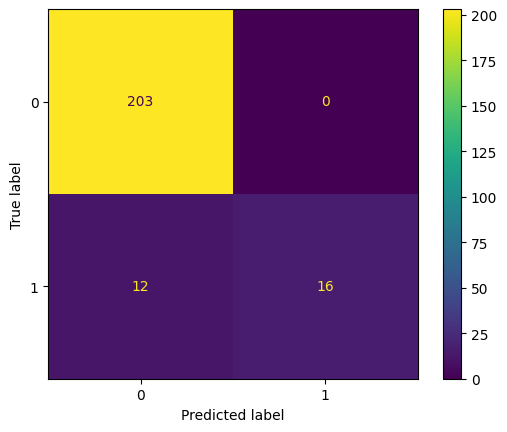

In [ ]:
outputs, targets = alg_model_trainer.validation()



plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

targets = list(chain.from_iterable(targets))
outputs = list(chain.from_iterable(outputs))

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(targets,outputs))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
recall = metrics.recall_score(targets, outputs)

print(f"Accuracy Score = {accuracy}")
print(f"Recall = {recall}")

In [ ]:
geo_data = problems_data.loc[problems_data['Geometry'] == True]
geo_data = geo_data[['year','instance','number','context','geo-labels']].reset_index()
geo_data

,index,year,instance,number,context,geo-labels
0,5,2019,A,6,many following types quadrilaterals exist poin...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,6,2019,A,7,"Two lines slopes \dfrac{1}{2} 2 intersect (2,2...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2,7,2019,A,8,"figure shows line \ell regular, infinite, recu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
3,12,2019,A,13,Let \triangle ABC isosceles triangle BC = AC \...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,15,2019,A,16,figure shows 13 circles radius 1 within larger...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]"
...,...,...,...,...,...,...
61,224,2022,A,25,"Let R, S, squares vertices lattice points (i.e...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
62,226,2022,B,2,"rhombus ABCD, point P lies segment \overline{A...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
63,240,2022,B,16,diagram shows rectangle side lengths 4 8 squar...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]"
64,244,2022,B,20,Let ABCD rhombus \angle ADC = 46^\circ. Let E ...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
geo_model, geo_training_loader, geo_testing_loader = generate_model(geo_data, 'geo-labels')
geo_optimizer = torch.optim.Adam(params=geo_model.parameters(), lr=LEARNING_RATE)
geo_model_trainer = ModelTraining(geo_model, geo_training_loader, geo_testing_loader, geo_optimizer)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for epoch in range(EPOCHS):
    geo_model_trainer.train_model(epoch)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.6866242289543152
Epoch: 1, Loss: 0.6031622290611267
Epoch: 2, Loss: 0.5427595376968384
Epoch: 3, Loss: 0.48550352454185486
Epoch: 4, Loss: 0.45568281412124634
Epoch: 5, Loss: 0.412649005651474
Epoch: 6, Loss: 0.40441808104515076
Epoch: 7, Loss: 0.4165487289428711
Epoch: 8, Loss: 0.4402424693107605
Epoch: 9, Loss: 0.3749485909938812
Epoch: 10, Loss: 0.35563191771507263
Epoch: 11, Loss: 0.33988040685653687
Epoch: 12, Loss: 0.4054053723812103
Epoch: 13, Loss: 0.3138065040111542
Epoch: 14, Loss: 0.32412290573120117
Epoch: 15, Loss: 0.37631234526634216
Epoch: 16, Loss: 0.35903531312942505
Epoch: 17, Loss: 0.3212187588214874
Epoch: 18, Loss: 0.2872486710548401
Epoch: 19, Loss: 0.2963283360004425
Epoch: 20, Loss: 0.28366416692733765
Epoch: 21, Loss: 0.24382683634757996
Epoch: 22, Loss: 0.2933122515678406
Epoch: 23, Loss: 0.2920951247215271
Epoch: 24, Loss: 0.3211290240287781
Epoch: 25, Loss: 0.3234802484512329
Epoch: 26, Loss: 0.35011905431747437
Epoch: 27, Loss: 0.331019639

In [ ]:
torch.save(top_level_model,'geometry-model-distilbert-amc10-2019-2022.pt')

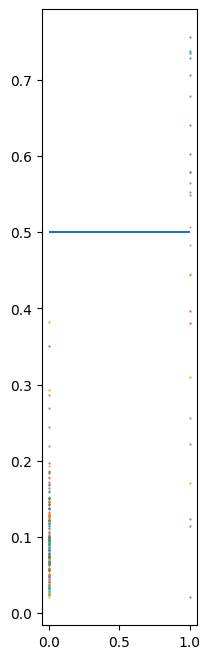

Accuracy Score = 0.9423076923076923
Recall = 0.5555555555555556


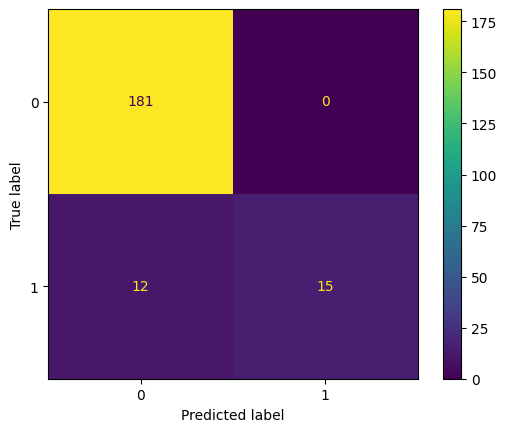

In [ ]:
outputs, targets = geo_model_trainer.validation()

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

targets = list(chain.from_iterable(targets))
outputs = list(chain.from_iterable(outputs))

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(targets,outputs))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
recall = metrics.recall_score(targets, outputs)

print(f"Accuracy Score = {accuracy}")
print(f"Recall = {recall}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


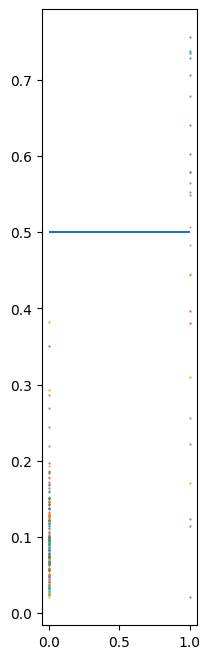

In [ ]:
outputs, targets = geo_model_trainer.validation()

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()